<a href="https://colab.research.google.com/github/kimdonggyu2008/deep_daiv_-/blob/main/auto_vc_advance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


각 화자별 wav 10개 이상


mel 파일 없어야 함



#시작

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import torch

# # 체크포인트 파일 로드
# checkpoint_path = '/content/drive/MyDrive/코딩공부/deep_daiv/dataset/checkpoint_step001000000_ema.pth'
# checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# # 체크포인트 파일의 최상위 키 목록 출력
# print("Top-level keys in the checkpoint:")
# for key in checkpoint.keys():
#     print(key)

# # 만약 state_dict가 존재한다면 그 안의 변수 목록을 확인
# if 'state_dict' in checkpoint:
#     print("\nKeys in 'state_dict':")
#     for key in checkpoint['state_dict'].keys():
#         print(key)


In [3]:
!pip install wavenet_vocoder

  Preparing metadata (setup.py) ... done
  Created wheel for wavenet_vocoder: filename=wavenet_vocoder-0.1.1-py3-none-any.whl size=12642 sha256=dbe55f21877d91ce9bcf83ef02e718fcabfd255d44f2fae230073ddaaa61913a
  Stored in directory: /root/.cache/pip/wheels/4f/a4/7b/f1d21f96be36a13e9c3948e8c28792bf8962da19781abd9dc8
Successfully built wavenet_vocoder


In [4]:
#!pip install wandb

In [5]:
#import wandb
#wandb.login()

In [6]:
import os

#os.environ['WANDB_API_KEY'] = '513a1f0c050fa7f60a76b5232e904d8df397082e'
# os.environ['WANDB_ENTITY'] = 'autovc'

In [7]:
import os
import pickle
import numpy as np
import soundfile as sf
from scipy import signal
from scipy.signal import get_window
from librosa.filters import mel
from numpy.random import RandomState
import torch
import torch.nn as nn
from collections import OrderedDict
import torch.nn.functional as F
from torch.utils import data
from multiprocessing import Process, Manager
import argparse
from torch.backends import cudnn
import time
import datetime

In [8]:
#make_spect.py
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq #차단할 주파수 대역 지정
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a #버터워스 고역 필터 계수


def pySTFT(x, fft_length=1024, hop_length=256): #stft실행

    x = np.pad(x, int(fft_length//2), mode='reflect') #패딩, 불연속성 완화

    noverlap = fft_length - hop_length #중첩된 샘플 수 계산
    shape = x.shape[:-1]+((x.shape[-1]-noverlap)//hop_length, fft_length)#??
    strides = x.strides[:-1]+(hop_length*x.strides[-1], x.strides[-1])#스트라이드 갯수 계산
    result = np.lib.stride_tricks.as_strided(x, shape=shape,
                                             strides=strides)#?? 윈도우변환??

    fft_window = get_window('hann', fft_length, fftbins=True) #해닝 창 함수 적용
    result = np.fft.rfft(fft_window * result, n=fft_length).T #ftf후 rftf적용

    return np.abs(result)


#wav, mel 데이터로더

In [9]:
mel_basis = mel(sr=16000,n_fft=1024,  n_mels=80, fmin=90, fmax=7600).T #멜 스펙트로그램 생성
#신호의 저주파 성분 제거
min_level = np.exp(-100 / 20 * np.log(10))
#작은 신호를 0말고 최솟값으로 변환
b, a = butter_highpass(30, 16000, order=5)
#고역필터 계수 지정

# audio file directory
rootDir = '/content/drive/MyDrive/코딩공부/deep_daiv/dataset/wavs'
# spectrogram directory
targetDir = '/content/drive/MyDrive/코딩공부/deep_daiv/dataset/spmel'


dirName, subdirList, _ = next(os.walk(rootDir))
if '.ipynb_checkpoints' in subdirList:
  subdirList.remove('.ipynb_checkpoints')
print('Found directory: %s' % dirName)


for subdir in sorted(subdirList): #데이터 파일 확인
    print(subdir)
    if not os.path.exists(os.path.join(targetDir, subdir)):#타겟 디렉토리 없으면 만듦
        os.makedirs(os.path.join(targetDir, subdir))
    _,_, fileList = next(os.walk(os.path.join(dirName,subdir)))#순차적 방문
    prng = RandomState(int(subdir[1:]))
    for fileName in sorted(fileList):
        # Read audio file
        x, fs = sf.read(os.path.join(dirName,subdir,fileName))#오디오파일 읽어오기
        # Remove drifting noise
        y = signal.filtfilt(b, a, x)#만든 고역필터 적용
        # Ddd a little random noise for model roubstness
        wav = y * 0.96 + (prng.rand(y.shape[0])-0.5)*1e-06
        # Compute spect
        D = pySTFT(wav).T #stft실행 후 스펙트로그램 생성
        # Convert to mel and normalize
        D_mel = np.dot(D, mel_basis)#스펙트로그램과 필터 뱅크 곱함 ??
        D_db = 20 * np.log10(np.maximum(min_level, D_mel)) - 16 #최소값 지정
        S = np.clip((D_db + 100) / 100, 0, 1)#결과값을 0~1로 제한해서 클리핑 제한
        # save spect
        np.save(os.path.join(targetDir, subdir, fileName[:-4]),
                S.astype(np.float32), allow_pickle=False)#멜스펙트로그램 저장

Found directory: /content/drive/MyDrive/코딩공부/deep_daiv/dataset/wavs
p001


#데이터로더

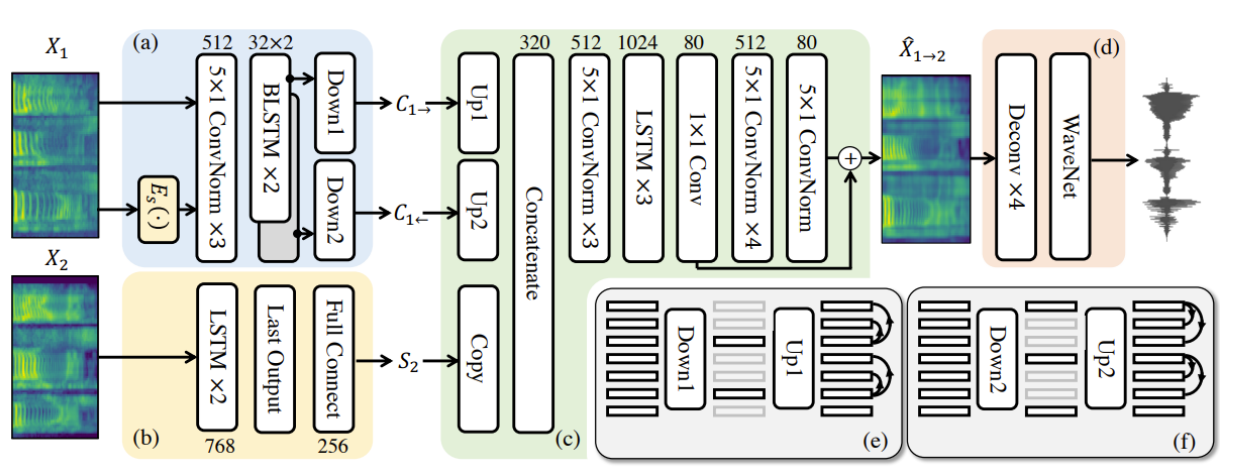

In [10]:
#model_bl.py

class D_VECTOR(nn.Module):#d벡터 모듈 생성, 내용물은 lstm으로 만들어짐
    """d vector speaker embedding."""
    def __init__(self, num_layers=3, dim_input=40, dim_cell=256, dim_emb=64):
        super(D_VECTOR, self).__init__()#모듈의 d_vector 상속
        self.lstm = nn.LSTM(input_size=dim_input, hidden_size=dim_cell,
                            num_layers=num_layers, batch_first=True)
        self.embedding = nn.Linear(dim_cell, dim_emb)#완전연결층


    def forward(self, x): #d벡터의 내부 모듈들
        self.lstm.flatten_parameters()#batch_size, sequence_len, n_feature
        lstm_out, _ = self.lstm(x)#batch_size,sequence_len,hidden_size
        embeds = self.embedding(lstm_out[:,-1,:])#sequence_len의 마지막을 임베딩으로 변환
        norm = embeds.norm(p=2, dim=-1, keepdim=True)
        embeds_normalized = embeds.div(norm)#batch_size, dim_emb
        return embeds_normalized#batch_size, dim_Emb


In [11]:
#make_metadata.py
"""
Generate speaker embeddings and metadata for training
"""

C = D_VECTOR(dim_input=80, dim_cell=768, dim_emb=256).eval().cuda() #화자별 임베딩
#C = D_VECTOR(dim_input=80, dim_cell=768, dim_emb=256).eval() #화자별 임베딩

c_checkpoint = torch.load('/content/drive/MyDrive/코딩공부/deep_daiv/dataset/3000000-BL.ckpt')
#c_checkpoint = torch.load('/content/drive/MyDrive/코딩공부/deep_daiv/dataset/3000000-BL.ckpt', map_location=torch.device('cpu'))

# c_checkpoint = torch.load('3000000-BL.ckpt')#발화자들의 데이터
new_state_dict = OrderedDict()
for key, val in c_checkpoint['model_b'].items():
    new_key = key[7:]
    new_state_dict[new_key] = val
C.load_state_dict(new_state_dict)

num_uttrs = 10
len_crop = 128


# Directory containing mel-spectrograms
rootDir = '/content/drive/MyDrive/코딩공부/deep_daiv/dataset/spmel'
# rootDir = './spmel'
dirName, subdirList, _ = next(os.walk(rootDir))
if '.ipynb_checkpoints' in subdirList:
  subdirList.remove('.ipynb_checkpoints')
print('Found directory: %s' % dirName)

speakers = [] #화자 전체의 임베딩 목록
for speaker in sorted(subdirList):
    print('Processing speaker: %s' % speaker)
    utterances = [] #단일 화자별 임베딩을 저장
    utterances.append(speaker)
    _, _, fileList = next(os.walk(os.path.join(dirName,speaker)))#하나씩 추출개시

    # make speaker embedding
    assert len(fileList) >= num_uttrs
    idx_uttrs = np.random.choice(len(fileList), size=num_uttrs, replace=False)
    embs = []
    for i in range(num_uttrs):
        tmp = np.load(os.path.join(dirName, speaker, fileList[idx_uttrs[i]]))
        #디렉토리, 화자, 화자별 파일 순으로 로딩
        candidates = np.delete(np.arange(len(fileList)), idx_uttrs)
        # choose another utterance if the current one is too short
        while tmp.shape[0] < len_crop:#지정 길이보다 짧으면 다른걸로 고름
            idx_alt = np.random.choice(candidates)
            tmp = np.load(os.path.join(dirName, speaker, fileList[idx_alt]))
            candidates = np.delete(candidates, np.argwhere(candidates==idx_alt))
        left = np.random.randint(0, tmp.shape[0]-len_crop)
        melsp = torch.from_numpy(tmp[np.newaxis, left:left+len_crop, :]).cuda()
        #주어진 간격(len_crop)만큼만 잘라서 학습에 활용
        emb = C(melsp)#해당 부분을 임베딩
        embs.append(emb.detach().squeeze().cpu().numpy())#해당 임베딩들 수집
    utterances.append(np.mean(embs, axis=0))#평균값으로 묶어서 화자 정보로 추가

    # create file list
    for fileName in sorted(fileList):#각 화자에 대한 정보 파일로 저장
        utterances.append(os.path.join(speaker,fileName))
    speakers.append(utterances)

with open(os.path.join(rootDir, 'train.pkl'), 'wb') as handle:
    pickle.dump(speakers, handle)

<ipython-input-11-d97734a81f91>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  c_checkpoint = torch.load('/content/drive/MyDrive/코딩공부/deep_daiv/dataset/3000000-BL.ck

Found directory: /content/drive/MyDrive/코딩공부/deep_daiv/dataset/spmel
Processing speaker: p001


In [ ]:
#data_loader.py


class Utterances(data.Dataset):
    """Dataset class for the Utterances dataset."""

    def __init__(self, root_dir, len_crop):
        """Initialize and preprocess the Utterances dataset."""
        self.root_dir = root_dir
        self.len_crop = len_crop
        self.step = 10

        metaname = os.path.join(self.root_dir, "train_kor.pkl") #메타데이터 읽어오기
        meta = pickle.load(open(metaname, "rb"))

        """Load data using multiprocessing"""
        manager = Manager()
        meta = manager.list(meta)
        dataset = manager.list(len(meta)*[None])
        processes = []
        for i in range(0, len(meta), self.step):
            p = Process(target=self.load_data,
                        args=(meta[i:i+self.step],dataset,i))#프로세스를 적용할 파일들
            p.start()
            processes.append(p)
        for p in processes:#프로세스 적용 후 저장
            p.join()

        self.train_dataset = list(dataset)
        self.num_tokens = len(self.train_dataset)

        print('Finished loading the dataset...')


    def load_data(self, submeta, dataset, idx_offset):#메타데이터 일부, 데이터셋 리스트, 인덱스 오프셋
        for k, sbmt in enumerate(submeta):
            uttrs = len(sbmt)*[None]#각 화자별로 넣을 수 있는 none칸 생성
            for j, tmp in enumerate(sbmt):#화자별로 ID 임베딩 저장
                if j < 2:  # fill in speaker id and embedding
                    uttrs[j] = tmp
                else: # load the mel-spectrograms

                    #해당 화자의 멜스펙트로그램 읽어옴
                    uttrs[j] = np.load(os.path.join(self.root_dir, tmp),allow_pickle=True)
                    #uttrs[j] = np.load(os.path.join(self.root_dir, tmp))


            dataset[idx_offset+k] = uttrs


    def __getitem__(self, index):#데이터셋의 인덱스
        # pick a random speaker
        dataset = self.train_dataset
        list_uttrs = dataset[index] #데이터셋 상에서 해당 인덱스를 가지는 화자 검색
        emb_org = list_uttrs[1]

        # pick random uttr with random crop
        a = np.random.randint(2, len(list_uttrs)) #무작위 화자 선택
        tmp = list_uttrs[a]
        if tmp.shape[0] < self.len_crop: #추출 길이보다 샘플이 짧음
            len_pad = self.len_crop - tmp.shape[0]#필요 길이까지 0으로 패딩 추가
            uttr = np.pad(tmp, ((0,len_pad),(0,0)), 'constant')
        elif tmp.shape[0] > self.len_crop:
            left = np.random.randint(tmp.shape[0]-self.len_crop)#랜덤위치 잡고 LEN_CROP길이 가져옴
            uttr = tmp[left:left+self.len_crop, :]
        else:
            uttr = tmp#같으면 전체 반환

        return uttr, emb_org


    def __len__(self):
        """Return the number of spkrs."""
        return self.num_tokens #샘플의 토큰 갯수 반환




def get_loader(root_dir, batch_size=16, len_crop=128, num_workers=0):
    """Build and return a data loader."""

    dataset = Utterances(root_dir, len_crop)

    worker_init_fn = lambda x: np.random.seed((torch.initial_seed()) % (2**32))
    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  worker_init_fn=worker_init_fn)
    return data_loader

# 모델

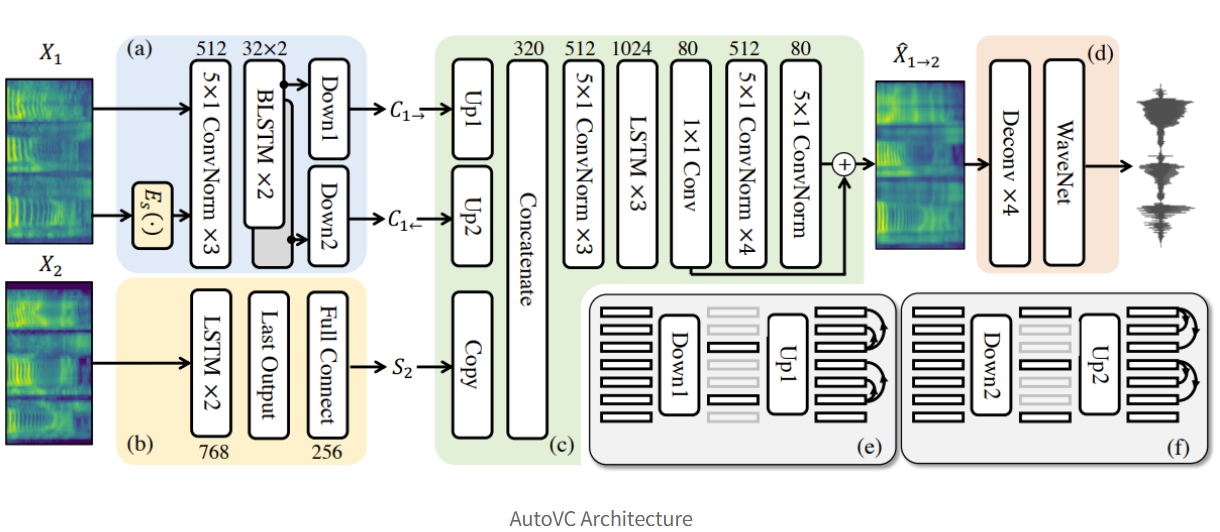

In [ ]:
import torch.nn.functional as F

In [ ]:
#model_vc.py

class LinearNorm(torch.nn.Module):#가중치 설정용 선형 놈
    def __init__(self, in_dim, out_dim, bias=True, w_init_gain='linear'):
        super(LinearNorm, self).__init__()
        self.linear_layer = torch.nn.Linear(in_dim, out_dim, bias=bias)#fc레이어

        torch.nn.init.xavier_uniform_(#가중치 분산이 입력데이터 갯수에 반비례하게 초기화됨
            self.linear_layer.weight,
            gain=torch.nn.init.calculate_gain(w_init_gain))#초기화 함수 지정

    def forward(self, x):
        return self.linear_layer(x)#fc레이어를 지나고 출력


class ConvNorm(torch.nn.Module): #합성곱 놈
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, bias=True, w_init_gain='linear'):
        super(ConvNorm, self).__init__()
        if padding is None:
            assert(kernel_size % 2 == 1) #입력값과 출력값의 크기를 동일하게 유지시킴
            padding = int(dilation * (kernel_size - 1) / 2)#커널 사이즈에 따라 패딩 조정, 크기 유지

        self.conv = torch.nn.Conv1d(in_channels, out_channels, #1D 컨볼루션 층, 시간따라 바뀌는것만 보면 됨
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    bias=bias)#1차원 컨볼루션 곱

        torch.nn.init.xavier_uniform_(#초기화
            self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal



#인코더


In [ ]:


class Encoder(nn.Module): #인코더 모델
    """Encoder module:
    """
    def __init__(self, dim_neck, dim_emb, freq):#보틀넥 구조 디멘션 갯수
        #첫번째 컨볼루션은 512+화자 임베딩, 512로 이루어짐
        #2, 3번째 컨볼루션은 512,512로 이루어짐
        super(Encoder, self).__init__()
        self.dim_neck = dim_neck
        self.freq = freq

        convolutions = []
        for i in range(3):
            conv_layer = nn.Sequential(#컨볼루션 3개 넣음
                ConvNorm(80+dim_emb if i==0 else 512,#입력이 주파수 대역 갯수 + 화자임베딩
                        #또는 원 크기?
                         512,
                         kernel_size=5, stride=1,
                         padding=2,
                         dilation=1, w_init_gain='relu'),
                nn.BatchNorm1d(512))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)

        self.lstm = nn.LSTM(512, dim_neck, 2, batch_first=True, bidirectional=True)
        #쌍방 LSTM

        #다운샘플링용 conv1d
        self.conv1=nn.Conv1d(in_channels=self.dim_neck,
                             out_channels=self.dim_neck,
                             kernel_size=self.freq,
                             stride=self.freq)


    def forward(self, x, c_org):#배치 사이즈, 1, 시간 프레임 T, 주파수대역 갯수 80
        #C_ORG = 화자 임베딩 1차원 스칼라
        x = x.squeeze(1).transpose(2,1)#배치사이즈, 주파수 대역, 시간 프래임
        c_org = c_org.unsqueeze(-1).expand(-1, -1, x.size(-1))#화자,화자, 시간프레임
        x = torch.cat((x, c_org), dim=1)# 원 오디오 콘텐츠 + 화자 임베딩

        for conv in self.convolutions:#화자+콘텐츠로 컨볼루션 곱 실행
            x = F.relu(conv(x)) #컨볼루션 레이어가 끝나고 활성화함수 적용
        x = x.transpose(1, 2)

        self.lstm.flatten_parameters() #lstm의 특징 추출
        outputs, _ = self.lstm(x)
        out_forward = outputs[:, :, :self.dim_neck] #순방향 lstm, dim neck의 뒷부분
        out_backward = outputs[:, :, self.dim_neck:] #역방향 lstm, dim neck의 앞부분

        codes = []
        #원본
        """
        for i in range(0, outputs.size(1) - (self.freq - 1), self.freq):#순방향 마지막, 역방향 첫번째 연결
          codes.append(torch.cat((out_forward[:,i+self.freq-1,:],out_backward[:,i,:]), dim=-1))
        """

        #avg_pooling 다운샘플링
        """
        for i in range(0, outputs.size(1), self.freq):#순방향 마지막, 역방향 첫번째 연결

            forward_slice = out_forward[:, i:i + self.freq, :]  # (batch_size, freq, dim_neck)
            backward_slice = out_backward[:, i:i + self.freq, :]  # (batch_size, freq, dim_neck)

            # freq 범위의 평균값을 추출하여 압축
            avg_pooled_forward = torch.mean(forward_slice, dim=1)  # (batch_size, dim_neck)
            avg_pooled_backward = torch.mean(backward_slice, dim=1)  # (batch_size, dim_neck)

            # 두 특징을 결합
            combined_code = torch.cat((avg_pooled_forward, avg_pooled_backward), dim=-1)  # (batch_size, dim_neck * 2)

            # codes 리스트에 추가
            codes.append(combined_code)
        """


        # 1d 컨볼루션

        out_forward_conv=self.conv1(out_forward.transpose(1,2)).transpose(1,2)
        out_backward_conv=self.conv1(out_backward.transpose(1,2)).transpose(1,2)
        for i in range(out_forward_conv.size(1)):
            combined_code = torch.cat((out_forward_conv[:, i, :], out_backward_conv[:, i, :]), dim=-1)  # (batch_size, dim_neck * 2)
            codes.append(combined_code)



        return codes


#디코더



In [ ]:

class Decoder(nn.Module): #디코더 모델
    """Decoder module:
    """
    def __init__(self, dim_neck, dim_emb, dim_pre, freq):#freq 를 따로 추가함
        super(Decoder, self).__init__()
        self.freq=freq
        self.lstm1 = nn.LSTM(dim_neck*2+dim_emb, dim_pre, 1, batch_first=True)#인코더 잠재표현+화자 임베딩

        convolutions = []
        for i in range(3):
            conv_layer = nn.Sequential( #컨볼루션 층 3개 지정, 모두 중간맵 크기로만 지정됨
                ConvNorm(dim_pre,
                         dim_pre,
                         kernel_size=5, stride=1,
                         padding=2,
                         dilation=1, w_init_gain='relu'),
                nn.BatchNorm1d(dim_pre))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)

        self.lstm2 = nn.LSTM(dim_pre, 1024, 2, batch_first=True)#lstm 2번째

        self.linear_projection = LinearNorm(1024, 80)

        #convtranpose 레이어 선언
        #원본은 freq값으로 80개를 하나로 묶었는데, 이걸 다시 80개로 늘려서 유사한 결과로 만듦
        self.conv_transpose=nn.ConvTranspose1d(in_channels=dim_pre,
                                               out_channels=dim_pre,
                                               kernel_size=256,
                                               stride=1)

    def forward(self, x): #학습 절차

        #self.lstm1.flatten_parameters()
        x, _ = self.lstm1(x)
        x = x.transpose(1, 2)

        for conv in self.convolutions:
            x = F.relu(conv(x))


        #convtranspose를 활용한 업샘플링

        x=self.conv_transpose(x)


        #interpolation을 활용한 업샘플링
        #주어진 freq값에 따라 upsampling
        """
        upsampled_length = x.size(2) * 16
        x = F.interpolate(x, size=upsampled_length, mode='linear', align_corners=True)
        """

        x = x.transpose(1, 2)

        outputs, _ = self.lstm2(x)

        decoder_output = self.linear_projection(outputs)

        return decoder_output



#인코더, 디코더 통합 차원 시간 테스트


In [ ]:
import torch
import torchaudio
import torchaudio.transforms as transforms
import time
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import librosa

In [ ]:
def plot_mel_spectrogram(mel_spectrogram, title="Mel-Spectrogram", cmap="inferno",figsize=(10, 4),db_min=-40,db_max=40):
    """
    Plot a mel-spectrogram.
    """
    mel_spectrogram_db = np.clip(mel_spectrogram, db_min, db_max)

    plt.figure(figsize=figsize)
    plt.imshow(mel_spectrogram_db.T, aspect='auto', origin='lower', interpolation='none', cmap=cmap)
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.show()


In [ ]:
import librosa
import numpy as np
import soundfile as sf

def mel_to_audio(mel_spectrogram, sr=16000, n_fft=1024, hop_length=256, n_iter=60):
    """
    Convert a mel-spectrogram back to a waveform using the Griffin-Lim algorithm.

    Args:
        mel_spectrogram (numpy.ndarray): Mel-spectrogram (shape: (n_mels, T))
        sr (int): Sample rate
        n_fft (int): Number of FFT components
        hop_length (int): Number of samples between successive frames
        n_iter (int): Number of iterations for Griffin-Lim algorithm

    Returns:
        numpy.ndarray: Reconstructed waveform
    """
    # Inverse mel-spectrogram to linear spectrogram
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=mel_spectrogram.shape[0])
    inv_mel_spectrogram = np.dot(np.linalg.pinv(mel_basis), mel_spectrogram)

    # Convert to magnitude spectrogram
    mag_spectrogram = np.maximum(1e-10, inv_mel_spectrogram)

    # Reconstruct the phase using Griffin-Lim
    waveform = librosa.griffinlim(mag_spectrogram, n_iter=n_iter, hop_length=hop_length, win_length=n_fft)

    return waveform

# Example usage:
# mel_spectrogram should be in linear scale before conversion
# combined_mel is the mel spectrogram that you wish to convert back to audio
# combined_mel shape should be (n_mels, T)

# combined_mel should be normalized between 0 to 1 before conversion, if it isn't already


<ipython-input-87-ac0202cfcd23>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/코딩공부/deep_daiv/dataset/checkpoint_step00100

Pre-trained parameters for encoder loaded successfully.
인코더 및 디코더 테스트 진행


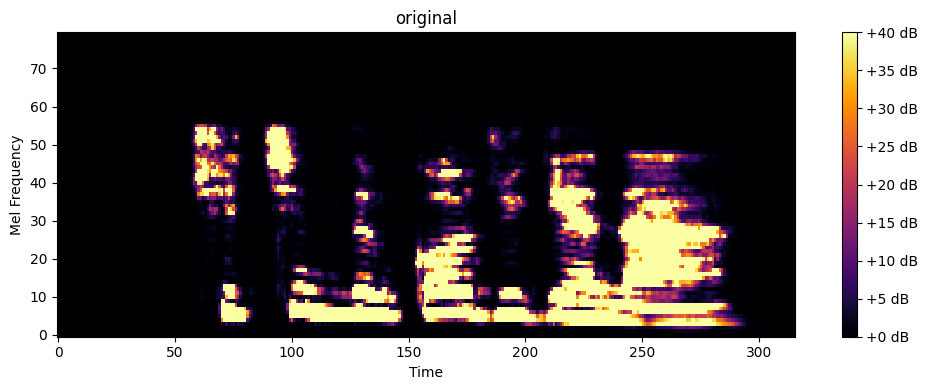

첫 번째 WAV 파일 인코더 출력 결과
Encoder Time elapsed: 0.017688 seconds
Input mel_spectrogram shape: torch.Size([1, 1, 316, 80])
Speaker embedding c_org shape: torch.Size([1, 256])
Output codes len: 19



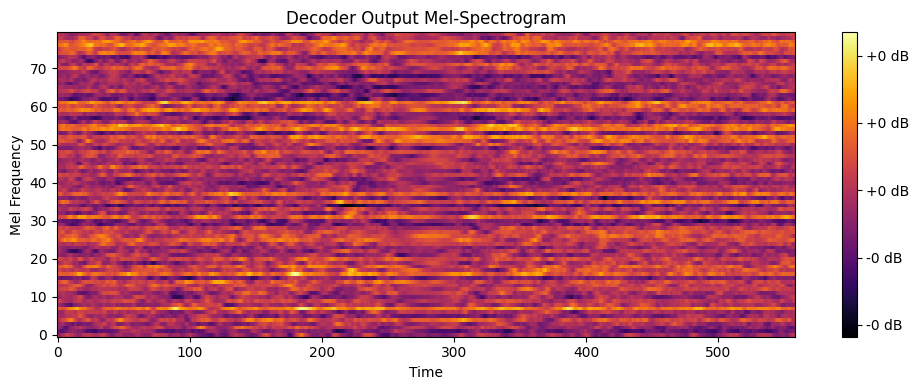

첫 번째 WAV 파일 디코더 출력 결과
Decoder Time elapsed: 0.619320 seconds
Decoder output shape: torch.Size([1, 559, 80])

WAV saved as 'decoder_output.wav'


In [ ]:
def load_wav_files(directory):
    """
    Load all WAV files from the specified directory.
    """
    wav_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.wav')]
    return wav_files

def wav_to_mel(filepath):
    """
    Convert a WAV file to a mel-spectrogram.
    """
    waveform, sample_rate = torchaudio.load(filepath)

    # Mel-spectrogram transformation
    mel_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,  # FFT window size
        hop_length=256,  # Number of samples between frames
        n_mels=80  # Mel bands
    )
    mel_spectrogram = mel_transform(waveform)

    return mel_spectrogram.squeeze(0).transpose(0, 1)  # Shape: (Time, Mel_freqs)


def test_encoder_decoder_with_wav():
    # 인코더 및 디코더 파라미터 설정
    dim_neck = 16  # LSTM hidden size
    dim_emb = 256  # Speaker embedding dimension
    dim_pre = 512  # Decoder intermediate map size
    freq = 16  # Downsampling and upsampling frequency

    # Encoder 및 Decoder 모델 초기화
    encoder = Encoder(dim_neck=dim_neck, dim_emb=dim_emb, freq=freq)
    decoder = Decoder(dim_neck=dim_neck, dim_emb=dim_emb, dim_pre=dim_pre, freq=freq)


    checkpoint = torch.load('/content/drive/MyDrive/코딩공부/deep_daiv/dataset/checkpoint_step001000000_ema.pth', map_location=torch.device('cpu'))

    # 인코더에 대한 사전 학습된 파라미터만 추출
    encoder_state_dict = checkpoint['state_dict']
    encoder_state_dict = {k.replace("encoder.", ""): v for k, v in encoder_state_dict.items() if k.startswith("encoder.")}

    # 인코더에 파라미터 적용
    encoder.load_state_dict(encoder_state_dict, strict=False)
    print("Pre-trained parameters for encoder loaded successfully.")



    #encoder.load_state_dict(torch.load('/content/drive/MyDrive/코딩공부/deep_daiv/dataset/3000000-BL.ckpt'))
    #decoder.load_state_dict(torch.load('/content/drive/MyDrive/코딩공부/deep_daiv/dataset/checkpoint_step001000000_ema.pth'))

    # Load the WAV files from the specified directory
    wav_directory = "/content/drive/MyDrive/코딩공부/deep_daiv/dataset/wavs/p001"
    wav_files = load_wav_files(wav_directory)

    # Use the first WAV file as test data
    if len(wav_files) == 0:
        print("No WAV files found in the specified directory.")
        return
    print("인코더 및 디코더 테스트 진행")

    # 첫 번째 WAV 파일에 대해서만 실행
    mel_spectrogram = wav_to_mel(wav_files[0])
    plot_mel_spectrogram(mel_spectrogram, title="original")

    # Adjust the mel_spectrogram for batch processing (add batch and channel dimensions)
    mel_spectrogram = mel_spectrogram.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, Time, Mel_freqs)

    # 화자 임베딩 벡터 생성 (batch_size, dim_emb)
    c_org = torch.randn(1, dim_emb)
    c_trg = torch.randn_like(c_org)

    # Encoder의 forward 함수 실행 및 시간 측정
    start = time.time()
    codes = encoder(mel_spectrogram, c_org)
    end = time.time()

    # 인코더 결과 출력
    print("첫 번째 WAV 파일 인코더 출력 결과")
    print(f"Encoder Time elapsed: {end - start:.6f} seconds")
    print(f"Input mel_spectrogram shape: {mel_spectrogram.shape}")
    print(f"Speaker embedding c_org shape: {c_org.shape}")
    print(f"Output codes len: {len(codes)}")
    print()

    # 인코더 출력값을 디코더 입력으로 변환
    tmp = []
    time_steps = mel_spectrogram.size(2)  # Get the time steps from the input
    for code in codes:
        expanded_code = code.unsqueeze(1).expand(-1, int(time_steps / len(codes)), -1)
        tmp.append(expanded_code)

    code_exp = torch.cat(tmp, dim=1)

    # 화자 임베딩 `c_trg`를 디코더 입력에 맞게 확장
    expanded_c_trg = c_trg.unsqueeze(1).expand(-1, code_exp.size(1), -1)  # (batch_size, seq_length, dim_emb)

    # 인코더 출력값과 화자 임베딩을 결합하여 디코더 입력 생성
    decoder_input = torch.cat((code_exp, expanded_c_trg), dim=-1)

    # 디코더 실행 및 시간 측정
    start = time.time()
    decoder_output = decoder(decoder_input)
    end = time.time()

    #decoder_output_mel_front = decoder_output.squeeze(0)[:400,:].detach().numpy()  # (Time, Mel_freqs)
    #plot_mel_spectrogram(decoder_output_mel_front, title=f"Decoder Output Mel-Spectrogram")
    """
    decoder_output_mel_back = decoder_output.squeeze(0)[-80:,:].detach().numpy()  # (Time, Mel_freqs)
    plot_mel_spectrogram(decoder_output_mel_back, title=f"Decoder Output Mel-Spectrogram")
    """
    decoder_output_mel = decoder_output.squeeze(0).detach().numpy()
    #decoder_output_mel_front = decoder_output.squeeze(0)[:80,:].detach().numpy()
    plot_mel_spectrogram(decoder_output_mel, title=f"Decoder Output Mel-Spectrogram")
    # 디코더 결과 출력
    print("첫 번째 WAV 파일 디코더 출력 결과")
    print(f"Decoder Time elapsed: {end - start:.6f} seconds")
    print(f"Decoder output shape: {decoder_output.shape}")
    print()

    waveform = mel_to_audio(decoder_output_mel.T, sr=16000, n_fft=1024, hop_length=256, n_iter=60)
    sf.write("decoder_output_front.wav", waveform, 16000)
    print("WAV saved as 'decoder_output.wav'")

    """
    waveform = mel_to_audio(decoder_output_mel_front.T, sr=16000, n_fft=1024, hop_length=256, n_iter=60)
    sf.write("decoder_output_front.wav", waveform, 16000)
    print("WAV saved as 'decoder_output.wav'")

    # Save the reconstructed waveform as a WAV file
    sf.write("reconstructed_audio.wav", waveform, 16000)
    """

# 테스트 함수 실행
test_encoder_decoder_with_wav()

#포스트넷, 생성기

In [ ]:

class Postnet(nn.Module): #포스트넷, 후처리 담당
    """Postnet
        - Five 1-d convolution with 512 channels and kernel size 5
    """

    def __init__(self):
        super(Postnet, self).__init__()
        self.convolutions = nn.ModuleList()

        self.convolutions.append(#컨볼루션 레이어 추가 80->512, 아마 주파수별 특징을 전체로 확장하는 것 같음
            nn.Sequential(
                ConvNorm(80, 512,
                         kernel_size=5, stride=1,
                         padding=2,
                         dilation=1, w_init_gain='tanh'),
                nn.BatchNorm1d(512))
        )

        for i in range(1, 5 - 1): #컨볼루션 3개, 512->512, 히든 레이어
            self.convolutions.append(
                nn.Sequential(
                    ConvNorm(512,
                             512,
                             kernel_size=5, stride=1,
                             padding=2,
                             dilation=1, w_init_gain='tanh'),
                    nn.BatchNorm1d(512))
            )

        self.convolutions.append(#마지막 512->80, 다시 줄임
            nn.Sequential(
                ConvNorm(512, 80,
                         kernel_size=5, stride=1,
                         padding=2,
                         dilation=1, w_init_gain='linear'),
                nn.BatchNorm1d(80))
            )

    def forward(self, x):#시행
        for i in range(len(self.convolutions) - 1):
            x = torch.tanh(self.convolutions[i](x))

        x = self.convolutions[-1](x)

        return x



In [ ]:

class Generator(nn.Module): #생성기 = 인코더+디코더+포스트넷
    """Generator network."""
    def __init__(self, dim_neck, dim_emb, dim_pre, freq, device):# 히든 차원 갯수, 화자 임베딩, 최종 결과 차원
        super(Generator, self).__init__()

        self.encoder = Encoder(dim_neck, dim_emb, freq).to(device)
        self.decoder = Decoder(dim_neck, dim_emb, dim_pre, freq).to(device)
        self.postnet = Postnet().to(device)

    def forward(self, x, c_org, c_trg):#생성기 생성

        codes = self.encoder(x, c_org)#batch_size, time_steps//freq, dim_neck
        if c_trg is None:
            return torch.cat(codes, dim=-1)

        tmp = []
        for code in codes:
            tmp.append(code.unsqueeze(1).expand(-1,int(x.size(1)/len(codes)),-1))
            #batch_size,1,dim_neck
            #batch_size, time_Steps//len(codes),dim_neck
        code_exp = torch.cat(tmp, dim=1)
        #두번째 차원으로 묶음

        encoder_outputs = torch.cat((code_exp, c_trg.unsqueeze(1).expand(-1,x.size(1),-1)), dim=-1)
        #최종적으로는 batch_size,time_steps, dim_neck+dim_emb로 변형

        mel_outputs = self.decoder(encoder_outputs)

        mel_outputs_postnet = self.postnet(mel_outputs.transpose(2,1))
        #batch_size, time_step, dim_pre에서 batch_size,dim_pre, time_Step으로 변형 후 포스트넷 적용

        mel_outputs_postnet = mel_outputs + mel_outputs_postnet.transpose(2,1)
        #잔차 적용으로 다시 원본으로 바꾼 후 더함

        mel_outputs = mel_outputs.unsqueeze(1)
        mel_outputs_postnet = mel_outputs_postnet.unsqueeze(1)

        return mel_outputs, mel_outputs_postnet, torch.cat(codes, dim=-1)
        #batch_size, time_Steps//freq, len(codes)*dim_neck?



# 학습

In [ ]:
#main.py

def str2bool(v):
    return v.lower() in ('true')


In [ ]:
cd /content/drive/MyDrive/코딩공부/deep_daiv/dataset

/content/drive/MyDrive/코딩공부/deep_daiv/dataset


In [ ]:
import sys

In [ ]:
sys.argv=[''] #명령어 만들어서 실행

parser = argparse.ArgumentParser()

# Model configuration.
parser.add_argument('--lambda_cd', type=float, default=1, help='weight for hidden code loss')
parser.add_argument('--dim_neck', type=int, default=16)
parser.add_argument('--dim_emb', type=int, default=256)
parser.add_argument('--dim_pre', type=int, default=512)
parser.add_argument('--freq', type=int, default=16)

# Training configuration.
parser.add_argument('--data_dir', type=str, default='./spmel')
parser.add_argument('--batch_size', type=int, default=2, help='mini-batch size')
parser.add_argument('--num_iters', type=int, default=1000000, help='number of total iterations')
parser.add_argument('--len_crop', type=int, default=128, help='dataloader output sequence length')
parser.add_argument('--checkpoint_interval', type=int, default=10)

# Miscellaneous.
parser.add_argument('--log_step', type=int, default=10)

config = parser.parse_args()

In [ ]:

#wandb.init(project="AutoVC baseline", config=config) #큰 프로젝트 이름
#wandb.run.name = 'origin' #각 run 구분 위한 이름

#solver_encoder


In [ ]:
# #solver_encoder.py

# def save_checkpoint(model, optimizer, epoch, iteration, checkpoint_dir='checkpoints', filename='checkpoint'):
#     if not os.path.exists(checkpoint_dir):
#         os.makedirs(checkpoint_dir)

#     checkpoint_path = os.path.join(checkpoint_dir, f'{filename}_epoch{epoch}_iter{iteration}.pth')
#     torch.save({

#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#     }, checkpoint_path)
#     print(f'Checkpoint saved at {checkpoint_path}')

# class Solver(object): #음성신호 학습

#     def __init__(self, vcc_loader, config):#입력된 변수들 받아서 저장
#         """Initialize configurations."""

#         # Data loader.
#         self.vcc_loader = vcc_loader

#         # Model configurations.
#         self.lambda_cd = config.lambda_cd
#         self.dim_neck = config.dim_neck
#         self.dim_emb = config.dim_emb
#         self.dim_pre = config.dim_pre
#         self.freq = config.freq

#         # Training configurations.
#         self.batch_size = config.batch_size
#         self.num_iters = config.num_iters

#         # Miscellaneous.
#         self.use_cuda = torch.cuda.is_available()
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.log_step = config.log_step

#         #체크포인트
#         self.checkpoint_interval = config.checkpoint_interval

#         # Build the model and tensorboard.
#         self.build_model()


#     def build_model(self): #모델 구축

#         self.G = Generator(self.dim_neck, self.dim_emb, self.dim_pre, self.freq, self.device)
#         #인코더, 디코더, 포스트넷으로 이루어진 생성기
#         self.g_optimizer = torch.optim.Adam(self.G.parameters(), 0.0001)
#         #옵티마이저 생성
#         self.G.to(self.device)
#         #지정된 장치로 수행


#     def reset_grad(self):
#         """Reset the gradient buffers."""
#         self.g_optimizer.zero_grad()#초기화


#     #=====================================================================================================================================#



#     def train(self):
#         # Set data loader.
#         data_loader = self.vcc_loader#데이터 로더 생성

#         # Print logs in specified order
#         keys = ['G/loss_id','G/loss_id_psnt','G/loss_cd']

#         # Start training.
#         print('Start training...')
#         start_time = time.time()
#         data_iter = iter(data_loader)
#         for i in range(self.num_iters):#데이터에 대해 반복시작

#             # =================================================================================== #
#             #                             1. Preprocess input data                                #
#             # =================================================================================== #

#             # Fetch data.
#             # Inside the train function
#             try:
#                 # Attempt to get the next batch of data
#                 x_real, emb_org = next(data_iter)
#             except StopIteration:
#                 # Reinitialize data_iter when the dataset is exhausted
#                 data_iter = iter(data_loader)
#                 x_real, emb_org = next(data_iter)




#             x_real = x_real.to(self.device)#실제 음성
#             emb_org = emb_org.to(self.device)#


#             # =================================================================================== #
#             #                               2. Train the generator                                #
#             # =================================================================================== #

#             self.G = self.G.train()

#             # Identity mapping loss
#             x_identic, x_identic_psnt, code_real = self.G(x_real, emb_org, emb_org)

#             g_loss_id = F.mse_loss(x_real, x_identic)
#             g_loss_id_psnt = F.mse_loss(x_real, x_identic_psnt)
#             #원본과 생성된 음성에 대한 차이값 계산
#             #psnt는 포스트넷을 지난 데이터에 대해서 평가


#             # Code semantic loss.
#             code_reconst = self.G(x_identic_psnt, emb_org, None)
#             g_loss_cd = F.l1_loss(code_real, code_reconst)
#             #생성된 음성을 원본과 비교해서 손실 계산

#             # Backward and optimize.
#             g_loss = g_loss_id + g_loss_id_psnt + self.lambda_cd * g_loss_cd
#             # 원본과 생성값, 후처리된 원본과 생성값, 코드손실값*비율 계산

#             self.reset_grad()
#             g_loss.backward()#역전파로 가중치 수정
#             self.g_optimizer.step()

#             # Logging.
#             loss = {}
#             loss['G/loss_id'] = g_loss_id.item()
#             loss['G/loss_id_psnt'] = g_loss_id_psnt.item()
#             loss['G/loss_cd'] = g_loss_cd.item()

#             # =================================================================================== #
#             #                                 4. Miscellaneous                                    #
#             # =================================================================================== #

#             # Print out training information.
            # if (i+1) % self.log_step == 0:
            #     et = time.time() - start_time
            #     et = str(datetime.timedelta(seconds=et))[:-7]
            #     log = "Elapsed [{}], Iteration [{}/{}]".format(et, i+1, self.num_iters)
            #     for tag in keys:
            #         log += ", {}: {:.4f}".format(tag, loss[tag])
            #     print(log)


#             if (i + 1) % self.checkpoint_interval == 0:
#                 save_checkpoint(self.G, self.g_optimizer, self.epoch, i + 1)




In [ ]:
import os
import torch

class Solver(object):
    def __init__(self, vcc_loader, config):
        """Initialize configurations."""
        # Data loader and configurations
        self.vcc_loader = vcc_loader

        # Model configurations
        self.lambda_cd = config.lambda_cd
        self.dim_neck = config.dim_neck
        self.dim_emb = config.dim_emb
        self.dim_pre = config.dim_pre
        self.freq = config.freq

        # Training configurations
        self.batch_size = config.batch_size
        self.num_iters = config.num_iters
        self.checkpoint_interval = config.checkpoint_interval  # Checkpoint interval

        # Miscellaneous
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.log_step = config.log_step

        # Build the model
        self.build_model()

    def build_model(self):
        self.G = Generator(self.dim_neck, self.dim_emb, self.dim_pre, self.freq, self.device)
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), 0.0001)
        self.G.to(self.device)

    def reset_grad(self):
        self.g_optimizer.zero_grad()

    def save_checkpoint(self, iteration, checkpoint_dir='checkpoints'):
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        checkpoint_path = os.path.join(checkpoint_dir, f'autovc_iter{iteration}.ckpt')

        checkpoint = {
            'iteration': iteration,
            'model_state_dict': self.G.state_dict(),
            'optimizer_state_dict': self.g_optimizer.state_dict(),
        }

        torch.save(checkpoint, checkpoint_path)
        print(f'Checkpoint saved at {checkpoint_path}')

    def train(self):
        # Set data loader
        data_loader = self.vcc_loader

        # Start training
        print('Start training...')
        start_time = time.time()
        data_iter = iter(data_loader)

        for iteration in range(1, self.num_iters + 1):
            try:
                x_real, emb_org = next(data_iter)
            except StopIteration:
                data_iter = iter(data_loader)
                x_real, emb_org = next(data_iter)

            x_real = x_real.to(self.device)
            emb_org = emb_org.to(self.device)

            self.G = self.G.train()
            x_identic, x_identic_psnt, code_real = self.G(x_real, emb_org, emb_org)
            g_loss_id = F.mse_loss(x_real, x_identic)
            g_loss_id_psnt = F.mse_loss(x_real, x_identic_psnt)
            code_reconst = self.G(x_identic_psnt, emb_org, None)
            g_loss_cd = F.l1_loss(code_real, code_reconst)

            g_loss = g_loss_id + g_loss_id_psnt + self.lambda_cd * g_loss_cd

            self.reset_grad()
            g_loss.backward()
            self.g_optimizer.step()

            # Print out training information
            if iteration % self.log_step == 0:
                elapsed_time = str(datetime.timedelta(seconds=int(time.time() - start_time)))
                print(f"Elapsed [{elapsed_time}], Iteration [{iteration}/{self.num_iters}], Loss: {g_loss.item()}")

            # Save a checkpoint at the specified interval
            if iteration % self.checkpoint_interval == 0:
                self.save_checkpoint(iteration)


#train

In [ ]:
cudnn.benchmark = True

    # Data loader.
vcc_loader = get_loader(config.data_dir, config.batch_size, config.len_crop)

solver = Solver(vcc_loader, config)

solver.train()



Finished loading the dataset...
Start training...


<ipython-input-45-72cfe2c992f4>:74: UserWarning: Using a target size (torch.Size([2, 1, 128, 80])) that is different to the input size (torch.Size([2, 128, 80])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  g_loss_id = F.mse_loss(x_real, x_identic)
<ipython-input-45-72cfe2c992f4>:75: UserWarning: Using a target size (torch.Size([2, 1, 128, 80])) that is different to the input size (torch.Size([2, 128, 80])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  g_loss_id_psnt = F.mse_loss(x_real, x_identic_psnt)


Elapsed [0:00:00], Iteration [10/1000000], Loss: 1.2294667959213257
Checkpoint saved at checkpoints/autovc_iter10.ckpt
Elapsed [0:00:02], Iteration [20/1000000], Loss: 1.0860965251922607
Checkpoint saved at checkpoints/autovc_iter20.ckpt
Elapsed [0:00:04], Iteration [30/1000000], Loss: 0.9041356444358826
Checkpoint saved at checkpoints/autovc_iter30.ckpt
Elapsed [0:00:05], Iteration [40/1000000], Loss: 0.7453268766403198


KeyboardInterrupt: 

In [ ]:
# Solver 객체 내에서 g_optimizer도 함께 저장합니다.
checkpoint = {
  'model': solver.G.state_dict(),
  'optimizer_state_dict': solver.g_optimizer.state_dict(),
}
torch.save(checkpoint, "autovc.ckpt")

In [ ]:
!pip install fvcore
!pip install torchinfo

In [ ]:
from fvcore.nn import parameter_count_table
from torchinfo import summary

def summarize_model(model, input_shape, is_cuda = False):
  global device

  if is_cuda:
    x = torch.rand(input_shape).to(device)
  else:
    x = torch.rand(input_shape)
  print(parameter_count_table(model))

  print(summary(model, input_size = input_shape))

In [ ]:
device = 'cuda:0'
G = Generator(16, 256, 512, 16).eval().to(device)
summarize_model(G, [16, 256, 512, 16], is_cuda = True)

#원본->대상 목소리 컨버젼


In [ ]:
import os
import pickle
import torch
import numpy as np
from math import ceil


def pad_seq(x, base=32):
    len_out = int(base * ceil(float(x.shape[0])/base))
    len_pad = len_out - x.shape[0]
    assert len_pad >= 0
    return np.pad(x, ((0,len_pad),(0,0)), 'constant'), len_pad

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator(16,256,512,16).eval().to(device)

g_checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/deepdaiv/autovc/autovc.ckpt',map_location=torch.device('cpu'))
G.load_state_dict(g_checkpoint['model'])

metadata = pickle.load(open('/content/drive/MyDrive/코딩공부/deep_daiv/dataset/spmel/train.pkl', "rb"))

spect_vc = []
"""
for sbmt_i in metadata: #현재는 각각에 대해서 전부 수행하게 만들어져 있음

    x_org = sbmt_i[2]
    x_org, len_pad = pad_seq(x_org)
    uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)#원본 음성
    emb_org = torch.from_numpy(sbmt_i[1][np.newaxis, :]).to(device)#원본 임베딩

    for sbmt_j in metadata:

        emb_trg = torch.from_numpy(sbmt_j[1][np.newaxis, :]).to(device)#타겟 임베딩

        with torch.no_grad():
            _, x_identic_psnt, _ = G(uttr_org, emb_org, emb_trg)

        if len_pad == 0:
            uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()
        else:
            uttr_trg = x_identic_psnt[0, 0, :-len_pad, :].cpu().numpy()

        spect_vc.append( ('{}x{}'.format(sbmt_i[0], sbmt_j[0]), uttr_trg) )

with open('/content/drive/MyDrive/Colab Notebooks/deepdaiv/autovc/results.pkl', 'wb') as handle:
    pickle.dump(spect_vc, handle)

"""

#단일->단일 화자 변환으로 코드 수정

# 변환하려는 원본 화자 ID와 타겟 화자 ID를 지정합니다.
source_speaker_id = "source_speaker_A"  # 변환할 원본 화자 ID
target_speaker_id = "target_speaker_B"  # 변환하고자 하는 타겟 화자 ID

# 원본 화자 정보를 찾습니다.
source_data = None
for sbmt_i in metadata:
    if sbmt_i[0] == source_speaker_id:
        source_data = sbmt_i
        break

if source_data is None:
    raise ValueError(f"Source speaker '{source_speaker_id}' not found in metadata.")

# 원본 화자의 스펙트로그램과 임베딩 벡터를 로드합니다.
x_org = source_data[2]
x_org, len_pad = pad_seq(x_org)
uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)  # 원본 스펙트로그램
emb_org = torch.from_numpy(source_data[1][np.newaxis, :]).to(device)  # 원본 화자의 임베딩 벡터

# 타겟 화자 정보를 찾습니다.
target_data = None
for sbmt_j in metadata:
    if sbmt_j[0] == target_speaker_id:
        target_data = sbmt_j
        break

if target_data is None:
    raise ValueError(f"Target speaker '{target_speaker_id}' not found in metadata.")

# 타겟 화자의 임베딩 벡터를 로드합니다.
emb_trg = torch.from_numpy(target_data[1][np.newaxis, :]).to(device)

# AutoVC 모델을 사용하여 변환을 수행합니다.
with torch.no_grad():
    _, x_identic_psnt, _ = G(uttr_org, emb_org, emb_trg)

# 변환된 스펙트로그램을 추출합니다.
if len_pad == 0:
    uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()
else:
    uttr_trg = x_identic_psnt[0, 0, :-len_pad, :].cpu().numpy()

# 변환된 결과를 리스트에 저장합니다.
spect_vc = []
spect_vc.append(('{}x{}'.format(source_speaker_id, target_speaker_id), uttr_trg))

# 변환 결과를 results.pkl 파일에 저장합니다.
with open('/content/drive/MyDrive/Colab Notebooks/deepdaiv/autovc/results_single.pkl', 'wb') as handle:
    pickle.dump(spect_vc, handle)

print(f"Voice conversion from '{source_speaker_id}' to '{target_speaker_id}' completed and saved to results_single.pkl")

NameError: name 'Generator' is not defined

In [ ]:
import pickle

# train.pkl 파일 경로를 올바르게 지정해 주세요
train_pkl_path = '/content/drive/MyDrive/코딩공부/deep_daiv/dataset/metadata.pkl'

# train.pkl 파일 로드
with open(train_pkl_path, 'rb') as handle:
    speakers = pickle.load(handle)

# 화자 ID 목록 추출 및 출력
speaker_ids = [speaker_data[0] for speaker_data in speakers]

print("Speaker IDs in train.pkl:")
for speaker_id in speaker_ids:
    print(speaker_id)

Speaker IDs in train.pkl:
p225
p228
p256
p270


# 보코더


In [ ]:
import torch
import soundfile as sf
import pickle
from tqdm import tqdm
from wavenet_vocoder import builder

In [ ]:
#hparams.py
# NOTE: If you want full control for model architecture. please take a look
# at the code and change whatever you want. Some hyper parameters are hardcoded.


class Map(dict): #보코더의 하이퍼 파라미터
	"""
    Example:
    m = Map({'first_name': 'Eduardo'}, last_name='Pool', age=24, sports=['Soccer'])

    Credits to epool:
    https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary
    """

	def __init__(self, *args, **kwargs): #딕셔너리 확장버전
		super(Map, self).__init__(*args, **kwargs)
		for arg in args:
			if isinstance(arg, dict):
				for k, v in arg.items():
					self[k] = v

		if kwargs:
			for k, v in kwargs.iteritems():
				self[k] = v

	def __getattr__(self, attr): #각 변수를 불러오는 방법
		return self.get(attr)

	def __setattr__(self, key, value):
		self.__setitem__(key, value)

	def __setitem__(self, key, value):
		super(Map, self).__setitem__(key, value)
		self.__dict__.update({key: value})

	def __delattr__(self, item):
		self.__delitem__(item)

	def __delitem__(self, key):
		super(Map, self).__delitem__(key)
		del self.__dict__[key]


# Default hyperparameters:
hparams = Map({ #하이퍼 파라미터 묶음
	'name': "wavenet_vocoder",

	# Convenient model builder
	'builder': "wavenet",

	# Input type:
	# 1. raw [-1, 1]
	# 2. mulaw [-1, 1]
	# 3. mulaw-quantize [0, mu]
	# If input_type is raw or mulaw, network assumes scalar input and
	# discretized mixture of logistic distributions output, otherwise one-hot
	# input and softmax output are assumed.
	# **NOTE**: if you change the one of the two parameters below, you need to
	# re-run preprocessing before training.
	'input_type': "raw",
	'quantize_channels': 65536,  # 65536 or 256

	# Audio:
	'sample_rate': 16000,
	# this is only valid for mulaw is True
	'silence_threshold': 2,
	'num_mels': 80,
	'fmin': 125,
	'fmax': 7600,
	'fft_size': 1024,
	# shift can be specified by either hop_size or frame_shift_ms
	'hop_size': 256,
	'frame_shift_ms': None,
	'min_level_db': -100,
	'ref_level_db': 20,
	# whether to rescale waveform or not.
	# Let x is an input waveform, rescaled waveform y is given by:
	# y = x / np.abs(x).max() * rescaling_max
	'rescaling': True,
	'rescaling_max': 0.999,
	# mel-spectrogram is normalized to [0, 1] for each utterance and clipping may
	# happen depends on min_level_db and ref_level_db, causing clipping noise.
	# If False, assertion is added to ensure no clipping happens.o0
	'allow_clipping_in_normalization': True,

	# Mixture of logistic distributions:
	'log_scale_min': float(-32.23619130191664),

	# Model:
	# This should equal to `quantize_channels` if mu-law quantize enabled
	# otherwise num_mixture * 3 (pi, mean, log_scale)
	'out_channels': 10 * 3,
	'layers': 24,
	'stacks': 4,
	'residual_channels': 512,
	'gate_channels': 512,  # split into 2 gropus internally for gated activation
	'skip_out_channels': 256,
	'dropout': 1 - 0.95,
	'kernel_size': 3,
	# If True, apply weight normalization as same as DeepVoice3
	'weight_normalization': True,
	# Use legacy code or not. Default is True since we already provided a model
	# based on the legacy code that can generate high-quality audio.
	# Ref: https://github.com/r9y9/wavenet_vocoder/pull/73
	'legacy': True,

	# Local conditioning (set negative value to disable))
	'cin_channels': 80,
	# If True, use transposed convolutions to upsample conditional features,
	# otherwise repeat features to adjust time resolution
	'upsample_conditional_features': True,
	# should np.prod(upsample_scales) == hop_size
	'upsample_scales': [4, 4, 4, 4],
	# Freq axis kernel size for upsampling network
	'freq_axis_kernel_size': 3,

	# Global conditioning (set negative value to disable)
	# currently limited for speaker embedding
	# this should only be enabled for multi-speaker dataset
	'gin_channels': -1,  # i.e., speaker embedding dim
	'n_speakers': -1,

	# Data loader
	'pin_memory': True,
	'num_workers': 2,

	# train/test
	# test size can be specified as portion or num samples
	'test_size': 0.0441,  # 50 for CMU ARCTIC single speaker
	'test_num_samples': None,
	'random_state': 1234,

	# Loss

	# Training:
	'batch_size': 2,
	'adam_beta1': 0.9,
	'adam_beta2': 0.999,
	'adam_eps': 1e-8,
	'amsgrad': False,
	'initial_learning_rate': 1e-3,
	# see lrschedule.py for available lr_schedule
	'lr_schedule': "noam_learning_rate_decay",
	'lr_schedule_kwargs': {},  # {"anneal_rate": 0.5, "anneal_interval": 50000},
	'nepochs': 2000,
	'weight_decay': 0.0,
	'clip_thresh': -1,
	# max time steps can either be specified as sec or steps
	# if both are None, then full audio samples are used in a batch
	'max_time_sec': None,
	'max_time_steps': 8000,
	# Hold moving averaged parameters and use them for evaluation
	'exponential_moving_average': True,
	# averaged = decay * averaged + (1 - decay) * x
	'ema_decay': 0.9999,

	# Save
	# per-step intervals
	'checkpoint_interval': 10000,
	'train_eval_interval': 10000,
	# per-epoch interval
	'test_eval_epoch_interval': 5,
	'save_optimizer_state': True,

	# Eval:
})


# def hparams_debug_string():
# 	values = hparams.values()
# 	hp = ['  %s: %s' % (name, values[name]) for name in sorted(values)]
# 	return 'Hyperparameters:\n' + '\n'.join(hp)

In [ ]:
torch.set_num_threads(4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def build_model(): #모델 생성

    model = getattr(builder, hparams.builder)(
        out_channels=hparams.out_channels,
        layers=hparams.layers,
        stacks=hparams.stacks,
        residual_channels=hparams.residual_channels,
        gate_channels=hparams.gate_channels,
        skip_out_channels=hparams.skip_out_channels,
        cin_channels=hparams.cin_channels,
        gin_channels=hparams.gin_channels,
        weight_normalization=hparams.weight_normalization,
        n_speakers=hparams.n_speakers,
        dropout=hparams.dropout,
        kernel_size=hparams.kernel_size,
        upsample_conditional_features=hparams.upsample_conditional_features,
        upsample_scales=hparams.upsample_scales,
        freq_axis_kernel_size=hparams.freq_axis_kernel_size,
        scalar_input=True,
        legacy=hparams.legacy,
    )
    return model



def wavegen(model, c=None, tqdm=tqdm): #파형 생성
    """Generate waveform samples by WaveNet.

    """

    model.eval()#평가모드
    model.make_generation_fast_() #빠른 생성?

    Tc = c.shape[0] #조건부 입력 길이
    upsample_factor = hparams.hop_size #업샘플링 비율
    # Overwrite length according to feature size
    length = Tc * upsample_factor #최종적 오디오 길이

    # B x C x T
    c = torch.FloatTensor(c.T).unsqueeze(0)#텐서 변환 후 차원 추가

    initial_input = torch.zeros(1, 1, 1).fill_(0.0) # 초기 입력값, 처음 데이터는 전부 0으로 이루어짐, 첫번째 윈도우

    # Transform data to GPU
    initial_input = initial_input.to(device)
    c = None if c is None else c.to(device)

    with torch.no_grad():#기울기 계산 없애고
        y_hat = model.incremental_forward(#오디오 한 샘플씩 생성
            initial_input, c=c, g=None, T=length, tqdm=tqdm, softmax=True, quantize=True,
            log_scale_min=hparams.log_scale_min)
        #initial - 처음 값
        #c - 조건부 입력(멜 스펙트로그램 같은 것)
        #t - 생성할 길이
        #softmax=확률분포를 통한 각 샘플 생성
        #quantization - 양자화 출력 여부
        #log_scale - 로그 스케일 최소값, 이하는 0으로 전부 묶음

    y_hat = y_hat.view(-1).cpu().data.numpy()#생성된 샘플을 1차원으로 변경, 합해서 후처리 시킴

    return y_hat

In [ ]:
#synthesis.py
# coding: utf-8
"""
Synthesis waveform from trained WaveNet.

Modified from https://github.com/r9y9/wavenet_vocoder
"""

torch.set_num_threads(4)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


In [ ]:
spect_vc = pickle.load(open('results.pkl', 'rb'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model().to(device)
checkpoint = torch.load("checkpoint_step001000000_ema.pth")
model.load_state_dict(checkpoint["state_dict"])

for spect in spect_vc:
    name = spect[0]
    c = spect[1]
    print(name)
    waveform = wavegen(model, c=c)
    sf.write(name+'.wav', waveform, samplerate=16000)